# Real or Not? NLP with Disaster Tweets

#### COMP 562 Final Project
##### November 21, 2020
Isabella Ford, Elizabeth Hensley, Margaret Lake, Kate Richardson

## Imports

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

## Load data in pandas dataframe

In [51]:
# Get the data, store as pandas dataframe
train_df_full = pd.read_csv("train.csv")
test_df_full = pd.read_csv("test.csv")

# Drop unused columns
train_df = train_df_full.drop(['keyword','location'],axis=1);
test_df = test_df_full.drop(['keyword','location'],axis=1);

In [52]:
# This is what the data looks like
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


## Data Cleaning

In [53]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def clean_text(text):
    text = ' '.join(x for x in text.split() if not x.startswith('http')) # Remove links
    text = ''.join([x for x in text if x in string.printable]) # Remove non-ASCII chars
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    text = remove_emoji(text) # Remove emojis
    return text

def process_text(df):
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    return df
    
train_df_cleaned = process_text(train_df)
test_df_cleaned = process_text(test_df)

train_df_cleaned.head()

,id,text,target,text_clean
0,1,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...
1,4,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,5,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...
3,6,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or..."
4,7,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...


In [54]:
# Example of a cleaned tweet - link removed here!
print(train_df_cleaned.at[7610,"text"])
print(train_df_cleaned.at[7610,"text_clean"])

M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ
M1.94 [01:04 UTC]?5km S of Volcano Hawaii.


## Data Processing

In [55]:
# Map tweets to feature vector with sklearn Coutn Vectorizer - counts word occurrences across all tweets
count_vectorizer = feature_extraction.text.CountVectorizer()

train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

In [56]:
# Map the cleaned data to feature vectors
train_vectors_cleaned = count_vectorizer.fit_transform(train_df_cleaned["text_clean"])
test_vectors_cleaned = count_vectorizer.transform(test_df_cleaned["text_clean"])

## Create DataFrames for storing Results

In [57]:
# Set up dataframe to hold cross validation values (3 folds)
cv_values = pd.DataFrame({'Fold':[1, 2, 3]})
cv_values.head()

,Fold
0,1
1,2
2,3


In [58]:
# Set up dataframe to hold predicted values for test data
# Drop unused columns
predicted_df = pd.read_csv("test.csv").drop(['keyword','location'],axis=1);
predicted_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


## Plot Settings for Confusion Matricies

In [59]:
# Default Plot settings for Confusion Matricies

def plotConfusionMatrix(confusion_mat, title="",font="Arial"):
    plt.figure(figsize=(5,5))
    plt.imshow(confusion_mat, interpolation='nearest', cmap='Pastel1')
    plt.title('Confusion Matrix \n' + title, size = 14, fontname=font)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["0", "1"], rotation=45, size = 10)
    plt.yticks(tick_marks, ["0", "1"], size = 10)
    plt.tight_layout()
    plt.ylabel('Actual label', size = 12, fontname=font)
    plt.xlabel('Predicted label', size = 12, fontname=font)
    width, height = confusion_mat.shape
    for x in range(width):
        for y in range(height):
            plt.annotate(str(confusion_mat[x][y]), xy=(y, x), size=12, fontname=font,
                            horizontalalignment='center', 
                            verticalalignment='center')

## Models

### Linear Fit

#### Uncleaned Data

In [60]:
# Linear Fit
clf_linear = linear_model.RidgeClassifier()

# Cross Validation
scores = model_selection.cross_val_score(clf_linear, train_vectors, train_df["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_linear.fit(train_vectors, train_df["target"])

# Predictions
predicted_df["Linear Fit, Unclean"] = clf_linear.predict(test_vectors)

# Add scores to cv_value dictionary
cv_values["Linear Fit, Unclean"] = scores

print(scores)
predicted_df.head()

[0.59485531 0.56498283 0.64149093]


,id,text,"Linear Fit, Unclean"
0,0,Just happened a terrible car crash,0
1,2,"Heard about #earthquake is different cities, s...",1
2,3,"there is a forest fire at spot pond, geese are...",1
3,9,Apocalypse lighting. #Spokane #wildfires,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1


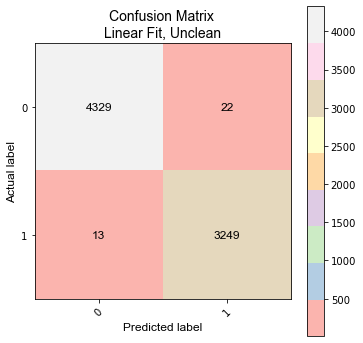

In [61]:
# Confusion Matrix - Linear Fit, Unclean
cmat = pd.DataFrame(confusion_matrix(train_df['target'], 
                    clf_linear.predict(train_vectors)))
plotConfusionMatrix(cmat, "Linear Fit, Unclean")

#### Cleaned Data

In [62]:
# Linear Fit - Cleaned Data
clf_linear_clean = linear_model.RidgeClassifier()

# Cross Validation
scores = model_selection.cross_val_score(clf_linear_clean, train_vectors_cleaned, train_df_cleaned["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_linear_clean.fit(train_vectors_cleaned, train_df_cleaned["target"])

# Predictions
predicted_df["Linear Fit Target, Clean"] = clf_linear_clean.predict(test_vectors_cleaned)

# Add scores to cv_value dictionary
cv_values["Linear Fit, Clean"] = scores

print(scores)
predicted_df.head()

[0.59088472 0.54958066 0.62338949]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean"
0,0,Just happened a terrible car crash,0,0
1,2,"Heard about #earthquake is different cities, s...",1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1


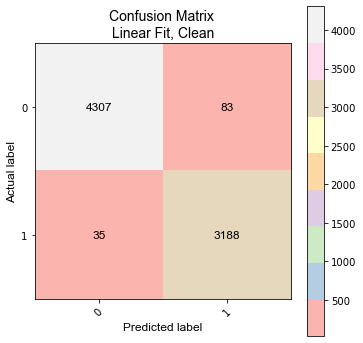

In [63]:
# Confusion Matrix - Linear Fit, Clean
cmat = pd.DataFrame(confusion_matrix(train_df_cleaned['target'], 
                    clf_linear_clean.predict(train_vectors_cleaned)))
plotConfusionMatrix(cmat, "Linear Fit, Clean")

### Basic Logistic Regression

#### Uncleaned Data

In [64]:
# Basic Logistic Regression, Unclean
clf_log_simple = linear_model.LogisticRegression(max_iter=500)

# Cross Validation
scores = model_selection.cross_val_score(clf_log_simple, train_vectors, train_df["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_log_simple.fit(train_vectors, train_df["target"])

# Predictions
predicted_df["Basic Logistic Regression, Unclean"] = clf_log_simple.predict(test_vectors)

# Add scores to cv_value dictionary
cv_values["Basic Logistic Regression, Unclean"] = scores

print(scores)
predicted_df.head()

[0.6387547  0.61347869 0.68285431]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean"
0,0,Just happened a terrible car crash,0,0,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1


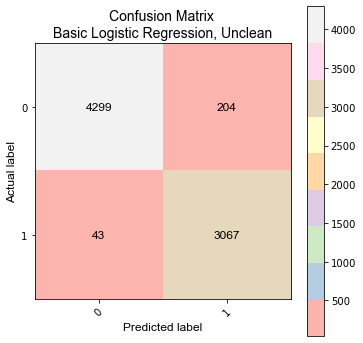

In [65]:
# Confusion Matrix - Basic Logistic Regression, Unclean
cmat = pd.DataFrame(confusion_matrix(train_df['target'], 
                    clf_log_simple.predict(train_vectors)))
plotConfusionMatrix(cmat, "Basic Logistic Regression, Unclean")

#### Cleaned

In [66]:
# Basic Logistic Regression, Cleaned Data
clf_log_simple_cleaned = linear_model.LogisticRegression(max_iter=500)

# Cross Validation
scores = model_selection.cross_val_score(clf_log_simple_cleaned, train_vectors_cleaned, train_df_cleaned["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_log_simple_cleaned.fit(train_vectors_cleaned, train_df_cleaned["target"])

# Predictions
predicted_df["Basic Logistic Regression, Clean"] = clf_log_simple_cleaned.predict(test_vectors_cleaned)

# Add scores to cv_value dictionary
cv_values["Basic Logistic Regression, Clean"] = scores

print(scores)
predicted_df.head()

[0.63546256 0.60152672 0.67911201]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean"
0,0,Just happened a terrible car crash,0,0,1,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1


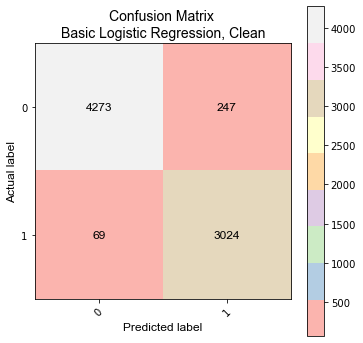

In [67]:
# Confusion Matrix - Basic Logistic Regression, Clean
cmat = pd.DataFrame(confusion_matrix(train_df_cleaned['target'], 
                    clf_log_simple_cleaned.predict(train_vectors_cleaned)))
plotConfusionMatrix(cmat, "Basic Logistic Regression, Clean")

### Weighted Logistic Regression

#### Unclean Data

In [68]:
# Weighted Logistic Regression, Unclean
clf_log_weighted = linear_model.LogisticRegression(max_iter=500, class_weight='balanced')

# Cross Validation
scores = model_selection.cross_val_score(clf_log_weighted, train_vectors, train_df["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_log_weighted.fit(train_vectors, train_df["target"])

# Predictions
predicted_df["Weighted Logistic Regression, Unclean"] = clf_log_weighted.predict(test_vectors)

# Add scores to cv_value dictionary
cv_values["Weighted Logistic Regression, Unclean"] = scores

print(scores)
predicted_df.head()

[0.65600825 0.62523901 0.69552941]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean","Weighted Logistic Regression, Unclean"
0,0,Just happened a terrible car crash,0,0,1,1,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0,0,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1,1


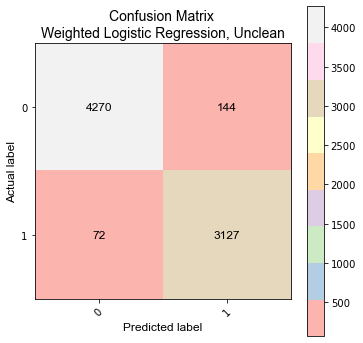

In [69]:
# Confusion Matrix - Weighted Logistic Regression, Unclean
cmat = pd.DataFrame(confusion_matrix(train_df['target'], 
                    clf_log_weighted.predict(train_vectors)))
plotConfusionMatrix(cmat, "Weighted Logistic Regression, Unclean")

#### Cleaned Data

In [70]:
# Weighted Logistic Regression, Cleaned Data
clf_log_weighted_cleaned = linear_model.LogisticRegression(max_iter=500, class_weight='balanced')

# Cross Validation
scores = model_selection.cross_val_score(clf_log_weighted_cleaned, train_vectors_cleaned, train_df_cleaned["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_log_weighted_cleaned.fit(train_vectors_cleaned, train_df_cleaned["target"])

# Predictions
predicted_df["Weighted Logistic Regression, Clean"] = clf_log_weighted_cleaned.predict(test_vectors_cleaned)

# Add scores to cv_value dictionary
cv_values["Weighted Logistic Regression, Clean"] = scores

print(scores)
predicted_df.head()

[0.64180672 0.61285645 0.68320611]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean","Weighted Logistic Regression, Unclean","Weighted Logistic Regression, Clean"
0,0,Just happened a terrible car crash,0,0,1,1,1,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1,1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1,1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0,0,0,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1,1,1


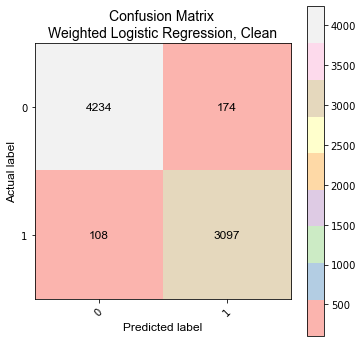

In [71]:
# Confusion Matrix - Weighted Logistic Regression, Clean
cmat = pd.DataFrame(confusion_matrix(train_df_cleaned['target'], 
                    clf_log_weighted_cleaned.predict(train_vectors_cleaned)))
plotConfusionMatrix(cmat, "Weighted Logistic Regression, Clean")

### Multinomial Naive Bayes - Learn Class Priors

#### Unclean Data

In [72]:
# Multinomial Naive Bayes Classification, Learn Class Prior Probs, Unclean
clf_multinb_lcpprob = MultinomialNB().fit(train_vectors, train_df['target'])

# Cross Validation
scores = model_selection.cross_val_score(clf_multinb_lcpprob, train_vectors, train_df["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_multinb_lcpprob.fit(train_vectors, train_df["target"])

# Predictions
predicted_df["Multinomial Naive Bayes Learn Priors, Unclean"] = clf_multinb_lcpprob.predict(test_vectors)

# Add scores to cv_value dictionary
cv_values["Multinomial Naive Bayes Learn Priors, Unclean"] = scores

print(scores)
predicted_df.head()

[0.66763006 0.6557971  0.72431507]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean","Weighted Logistic Regression, Unclean","Weighted Logistic Regression, Clean","Multinomial Naive Bayes Learn Priors, Unclean"
0,0,Just happened a terrible car crash,0,0,1,1,1,1,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1,1,1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1,1,1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0,0,0,1,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1,1,1,1


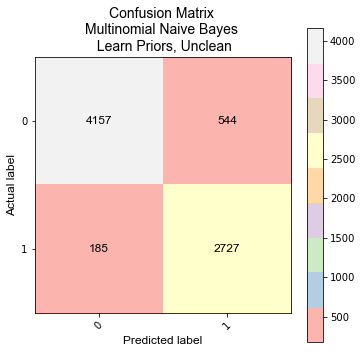

In [73]:
# Confusion Matrix - Multinomial Naive Bayes Learn Priors, Unclean
cmat = pd.DataFrame(confusion_matrix(train_df['target'], 
                    clf_multinb_lcpprob.predict(train_vectors)))
plotConfusionMatrix(cmat, "Multinomial Naive Bayes \n Learn Priors, Unclean")

#### Cleaned Data

In [74]:
# Multinomial Naive Bayes Classification, Learn Class Prior Probs, Cleaned Data
clf_multinb_lcpprob_clean = MultinomialNB().fit(train_vectors_cleaned, train_df_cleaned['target'])

# Cross Validation
scores= model_selection.cross_val_score(clf_multinb_lcpprob_clean, train_vectors_cleaned, train_df_cleaned["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_multinb_lcpprob_clean.fit(train_vectors_cleaned, train_df_cleaned["target"])

# Predictions
predicted_df["Multinomial Naive Bayes Learn Priors, Clean"] = clf_multinb_lcpprob_clean.predict(test_vectors_cleaned)

# Add scores to cv_value dictionary
cv_values["Multinomial Naive Bayes Learn Priors, Clean"] = scores

print(scores)
predicted_df.head()

[0.68097561 0.65970962 0.73198101]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean","Weighted Logistic Regression, Unclean","Weighted Logistic Regression, Clean","Multinomial Naive Bayes Learn Priors, Unclean","Multinomial Naive Bayes Learn Priors, Clean"
0,0,Just happened a terrible car crash,0,0,1,1,1,1,1,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1,1,1,1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1,1,1,1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0,0,0,1,1,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1,1,1,1,1


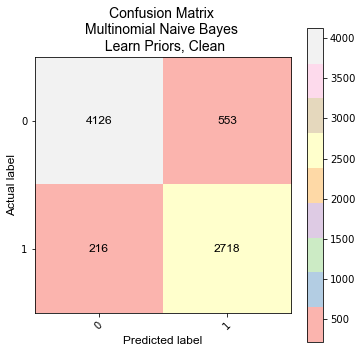

In [75]:
# Confusion Matrix - Multinomial Naive Bayes Learn Priors, Clean
cmat = pd.DataFrame(confusion_matrix(train_df_cleaned['target'], 
                    clf_multinb_lcpprob_clean.predict(train_vectors_cleaned)))
plotConfusionMatrix(cmat, "Multinomial Naive Bayes \n Learn Priors, Clean")

### Multinomial Naive Bayes - Uniform Priors

#### Unclean Data

In [76]:
# Multinomial Naive Bayes Classification, Uniform Priors, Unclean
clf_multinb_unifpri = MultinomialNB(fit_prior=False).fit(train_vectors, train_df['target'])

# Cross Validation
scores = model_selection.cross_val_score(clf_multinb_unifpri, train_vectors, train_df["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_multinb_unifpri.fit(train_vectors, train_df["target"])

# Predictions
predicted_df["Multinomial Naive Bayes Uniform Priors, Unclean"] = clf_multinb_unifpri.predict(test_vectors)

# Add scores to cv_value dictionary
cv_values["Multinomial Naive Bayes Uniform Priors, Unclean"] = scores

print(scores)
predicted_df.head()

[0.66697545 0.65608466 0.71756362]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean","Weighted Logistic Regression, Unclean","Weighted Logistic Regression, Clean","Multinomial Naive Bayes Learn Priors, Unclean","Multinomial Naive Bayes Learn Priors, Clean","Multinomial Naive Bayes Uniform Priors, Unclean"
0,0,Just happened a terrible car crash,0,0,1,1,1,1,1,1,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1,1,1,1,1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1,1,1,1,1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0,0,0,1,1,1,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1,1,1,1,1,1


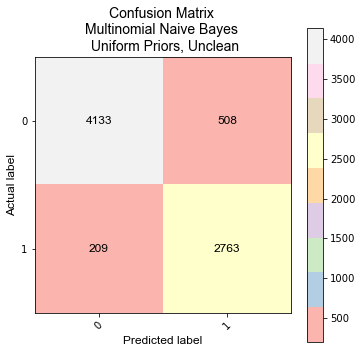

In [77]:
# Confusion Matrix - Multinomial Naive Bayes Uniform Priors, Unclean
cmat = pd.DataFrame(confusion_matrix(train_df['target'], 
                    clf_multinb_unifpri.predict(train_vectors)))
plotConfusionMatrix(cmat, "Multinomial Naive Bayes \n Uniform Priors, Unclean")

#### Cleaned Data

In [78]:
# Multinomial Naive Bayes Classification, Uniform Priors, Cleaned Data
clf_multinb_unifpri_clean = MultinomialNB(fit_prior=False).fit(train_vectors_cleaned, train_df_cleaned['target'])

# Cross Validation
scores= model_selection.cross_val_score(clf_multinb_unifpri_clean, train_vectors_cleaned, train_df_cleaned["target"], 
                                         cv=3, scoring="f1")

# Fit the model to training data
clf_multinb_unifpri_clean.fit(train_vectors_cleaned, train_df_cleaned["target"])

# Predictions
predicted_df["Multinomial Naive Bayes Uniform Priors, Clean"]= clf_multinb_unifpri_clean.predict(test_vectors_cleaned)

# Add scores to cv_value dictionary
cv_values["Multinomial Naive Bayes Uniform Priors, Clean"] = scores

print(scores)
predicted_df.head()

[0.6775854  0.66283694 0.71973466]


,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean","Weighted Logistic Regression, Unclean","Weighted Logistic Regression, Clean","Multinomial Naive Bayes Learn Priors, Unclean","Multinomial Naive Bayes Learn Priors, Clean","Multinomial Naive Bayes Uniform Priors, Unclean","Multinomial Naive Bayes Uniform Priors, Clean"
0,0,Just happened a terrible car crash,0,0,1,1,1,1,1,1,1,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1,1,1,1,1,1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1,1,1,1,1,1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0,0,0,1,1,1,1,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1,1,1,1,1,1,1


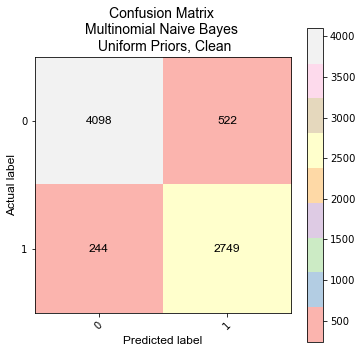

In [79]:
# Confusion Matrix - Multinomial Naive Bayes Uniform Priors, Clean
cmat = pd.DataFrame(confusion_matrix(train_df_cleaned['target'], 
                    clf_multinb_unifpri_clean.predict(train_vectors_cleaned)))
plotConfusionMatrix(cmat, "Multinomial Naive Bayes \n Uniform Priors, Clean")

## Results

### Predictions

In [80]:
# First few predictions from each model
predicted_df.head()

,id,text,"Linear Fit, Unclean","Linear Fit Target, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean","Weighted Logistic Regression, Unclean","Weighted Logistic Regression, Clean","Multinomial Naive Bayes Learn Priors, Unclean","Multinomial Naive Bayes Learn Priors, Clean","Multinomial Naive Bayes Uniform Priors, Unclean","Multinomial Naive Bayes Uniform Priors, Clean"
0,0,Just happened a terrible car crash,0,0,1,1,1,1,1,1,1,1
1,2,"Heard about #earthquake is different cities, s...",1,1,1,1,1,1,1,1,1,1
2,3,"there is a forest fire at spot pond, geese are...",1,1,1,1,1,1,1,1,1,1
3,9,Apocalypse lighting. #Spokane #wildfires,0,1,0,0,0,1,1,1,1,1
4,11,Typhoon Soudelor kills 28 in China and Taiwan,1,1,1,1,1,1,1,1,1,1


### Cross Validation Values

In [81]:
# All the cross validation values per 3 folds for each model
cv_values

,Fold,"Linear Fit, Unclean","Linear Fit, Clean","Basic Logistic Regression, Unclean","Basic Logistic Regression, Clean","Weighted Logistic Regression, Unclean","Weighted Logistic Regression, Clean","Multinomial Naive Bayes Learn Priors, Unclean","Multinomial Naive Bayes Learn Priors, Clean","Multinomial Naive Bayes Uniform Priors, Unclean","Multinomial Naive Bayes Uniform Priors, Clean"
0,1,0.594855,0.590885,0.638755,0.635463,0.656008,0.641807,0.667630,0.680976,0.666975,0.677585
1,2,0.564983,0.549581,0.613479,0.601527,0.625239,0.612856,0.655797,0.659710,0.656085,0.662837
2,3,0.641491,0.623389,0.682854,0.679112,0.695529,0.683206,0.724315,0.731981,0.717564,0.719735
